In [106]:
## Analysis of 3d Truss structures
import sys, os
import numpy as np

import cvxpy as cp
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
  
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  cwdGoogle = '/content/drive/MyDrive/AIM/projects/2022_truss_optimization/pythonTrussFEM/'
  sys.path.append(cwdGoogle)
else:
  cwdGoogle = ''
  
from trussFEM import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 3D Truss analysis
 assuming linear elasticity and truss elements



In [113]:
# Folder containing all your models
inputFolder='input/'
# Sub folder containing the particular model for analysis
inputModel='25_bar/'
# The unit which to do the simulation and optimization in, note the input files are always in m
inputUnit='mm'
# Whether to plot results or not
inputPlot=1

# tog - plot ON/OFF, deform shape , modal shape, modal #, scale of def, color 1=stress, 2=mat
plotting = dict()
plotting['IO']=True # true - plot, false - do not plot
plotting['deformed']= 2 # 0 - original, 1 - deformed, 2 - both

# Read data from file and put all in matlab tables
cwd=cwdGoogle+inputFolder+inputModel

[inputData, num] = importData(cwd, inputUnit)

# Initialization of material and geometrical properties
# Initialize # of DOF, calculate elem. and glb. DOF, and material yield strength, stiffness, and cross sectional area
# Construct a struct containing all of this information per element
[glb, elem, num] = initializeStruct(inputData, num)

# assemble adjacency matrix
[glb['C'], glb['A'], elem['L']] = assembleA(num, inputData['nodes'], elem['n0'],elem['n1'])

# construct element wise stiffness
elem['B'] = elem['E']*elem['A']/elem['L']

# assemble material stiffness matrix
glb['Km']  = assembleKm(glb['A'],elem['B'], num)

# solve the linear system
[glb,elem,status] = SolverLE(glb, elem, num)

glb['Volume']=sum(elem['A']*elem['L'])

# Equilibrium, compatibility and stiffness check
print('Equilibrium (Af+F)^2 MSE='      + str(status['equilibrium']))
print('Compatibility (Bf+A^Tu)^2 MSE=' + str(status['compatibility']))
print('Stiffness mean (Ku-F)^2 MSE='   + str(status['stiffness']))


Equilibrium (Af+F)^2 MSE=2.4370853248320686e-22
Compatibility (Bf+A^Tu)^2 MSE=3.9195683633818355e-34
Stiffness mean (Ku-F)^2 MSE=2.346627499236817e-22


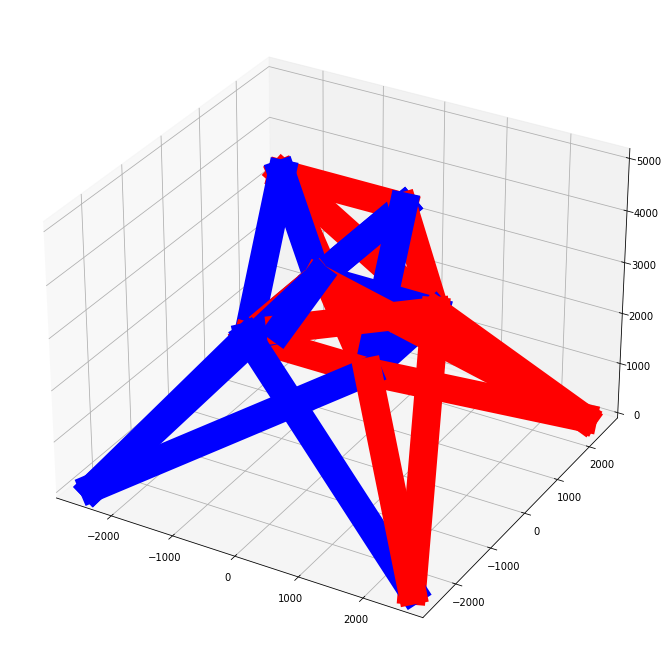

In [114]:
if plotting['IO']==True:
    plotStructFun(glb, elem, inputData, inputUnit, elem['A'], elem['f'], plotting)

### Linear programming:
Minimize volume by optimizing with cross section, constrained by yield stress and minimum and maximum cross section area

In [115]:
def optTrussLP(glb, elem, num, mtd, yieldStress, minA, maxA):
    f_id  = np.ix_(glb['fDOF'])
    if mtd == 'scipy':

        c    = np.hstack((np.zeros(num['m']), elem['L']))

        A_eq = np.hstack((glb['A'][f_id], np.zeros((len(glb['fDOF']),num['m']))))
        b_eq = -glb['F'][f_id]

        A_ub = np.zeros((num['m']*2, num['m']*2))
        b_ub = np.zeros(num['m']*2)

        lb   = np.zeros(num['m']*2)
        ub   = np.zeros(num['m']*2)

        for i in np.arange(num['m']):
            A_ub[i,          i]          = -1.
            A_ub[i,          i+num['m']] = -yieldStress
            A_ub[i+num['m'], i]          =  1.
            A_ub[i+num['m'], i+num['m']] = -yieldStress

            lb[i]          = None
            ub[i]          = None
            lb[i+num['m']] = minA
            ub[i+num['m']] = maxA

        bounds= [(ubi,lbi) for ubi,lbi in zip(lb,ub)]

        from scipy.optimize import linprog
        res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds = bounds)
        a_opt = res['x'][num['m']:]
        f_opt = res['x'][0:num['m']]
        
    elif mtd =='cvx':

        # Import packages.
        a = cp.Variable(num['m'])
        f = cp.Variable(num['m'])
        prob = cp.Problem(cp.Minimize(elem['L'].T@a), \
                          [- np.eye(num['m'])*yieldStress @ a <= f] + \
                          [ f <= np.eye(num['m'])*yieldStress @ a] + \
                          [glb['A'][f_id] @ f == -glb['F'][f_id]])      # equilibrium constraint
        prob.solve(solver="SCS")
        a_opt = a.value
        f_opt = f.value
    return [a_opt,f_opt]

[a_opt,f_opt]=optTrussLP(glb, elem, num, 'cvx',  inputData['parameters']['yieldStress'], inputData['parameters']['minA'], inputData['parameters']['maxA'])


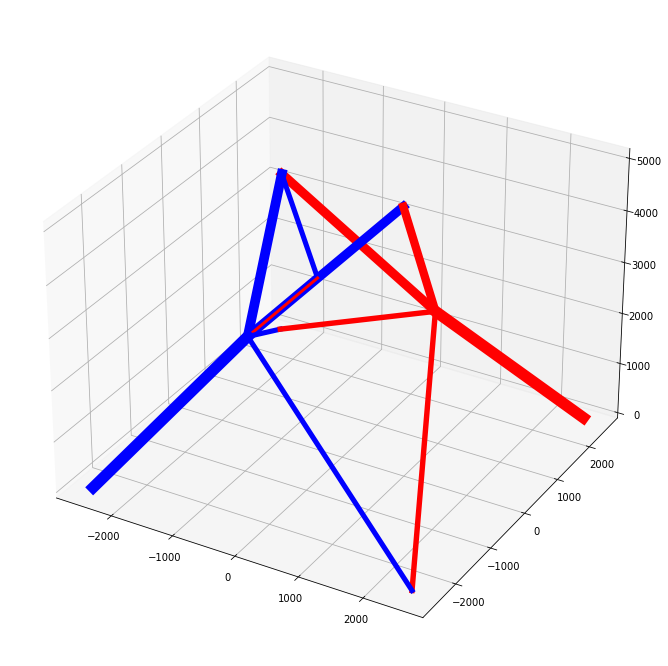

In [116]:

if plotting['IO']==True:
    plotStructFun(glb, elem, inputData, inputUnit, a_opt, f_opt, plotting)

### SOCP programming:
Minimize compliance + volume by optimizing with cross section, constrained by yield stress and minimum and maximum cross section area

In [117]:
# Import packages.
import cvxpy as cp
import numpy as np
def optTrussSOCP(glb, elem, num, yieldStress, d_max, V_max):
    f_id  = np.ix_(glb['fDOF'])
    
    f_obj    = np.ones(num['m'])
    
    LE = np.sqrt(elem['L']/elem['E'])
    
    M  = np.eye(num['m'])
    d  = np.ones(num['m']) * d_max  
    # Define and solve the CVXPY problem.
    f = cp.Variable(num['m'])
    w = cp.Variable(num['m'])
    y = cp.Variable(num['m'])
    
    # We use cp.SOC(t, x) to create the SOC constraint ||x||_2 <= t.

    soc_constraints = [cp.SOC(w[i],cp.hstack([LE[i] * f[i], y[i]])) for i in range(num['m'])]

    prob = cp.Problem(
                    cp.Minimize(
                    1/2*f_obj.T@(w+y)     # objective, minimizing compliance
                    #+1/2*elem['L'].T @ (w-y) # objective, minimizing  and volume (This doesn't work well, we need to tune the weight)
                    ), 
                    soc_constraints  
                      + [glb['A'][f_id] @ f == -glb['F'][f_id]]          # equilibrium constraint
                      + [M @ (w-y) <= d]                                 # individual max area constraint
                      + [elem['L'].T @ (w-y) <= V_max]                   # Total volume constraint
                      + [- np.eye(num['m'])*yieldStress @ (w-y) <= f]    # lower stress bound
                      + [ f <= np.eye(num['m'])*yieldStress @ (w-y)]    # upper stress bound
                     )
    prob.solve(solver='SCS')
    
    a_opt = w.value - y.value
    s_opt = w.value + y.value
    
    return [a_opt,f_opt]

[a_opt,f_opt] = optTrussSOCP(glb, elem, num,   inputData['parameters']['yieldStress'], inputData['parameters']['maxA'], 0.0005*sum(inputData['parameters']['maxA']*elem['L']))



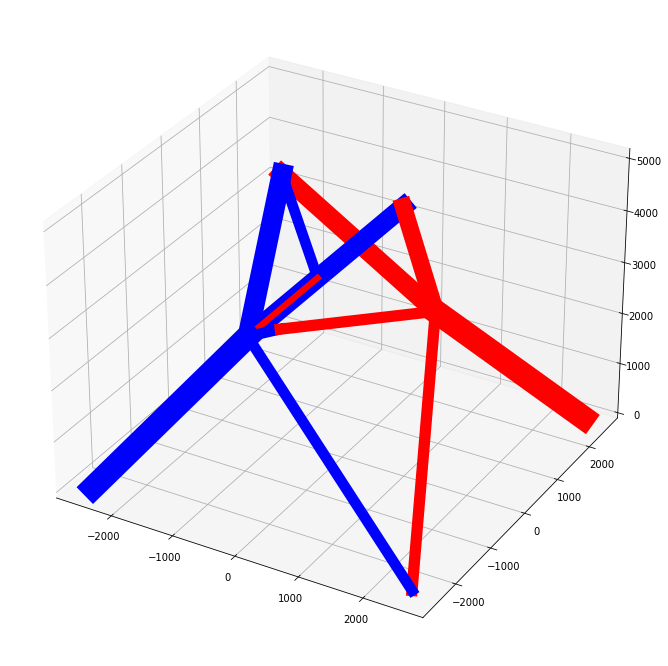

In [118]:

if plotting['IO']==True:
    plotStructFun(glb, elem, inputData, inputUnit, a_opt, f_opt, plotting)

In [8]:
# Alternative formulation - may be useful if we cannot use cvx

import cvxpy as cp
import numpy as np

def optTrussSOCP(glb, elem, num):
    f_id  = np.ix_(glb['fDOF'])
    
    # c is f
    c    = np.hstack((np.zeros(num['m']),np.ones(num['m']),np.ones(num['m'])))
    
    # Af = -F, This is F x = g in https://www.cvxpy.org/examples/basic/socp.html
    A_eq = np.hstack((glb['A'][f_id], np.zeros((len(glb['fDOF']),num['m'])), np.zeros((len(glb['fDOF']),num['m']))))

    b_eq = -glb['F'][f_id]
    
    # || L/E f^2 + y || < w
    
    # LE = A
    LE = np.hstack((np.diag(np.sqrt(elem['L']/elem['E'])), np.zeros((num['m'],num['m'])), np.zeros((num['m'],num['m']))))
    # y = b
    y  = np.hstack((np.eye(num['m'])*0., np.eye(num['m'])*0.,  np.eye(num['m'])))
    # w = c
    w  = np.hstack((np.eye(num['m'])*0., np.eye(num['m']),     np.eye(num['m'])*0.))
    
    M  = np.hstack((np.eye(num['m'])*0., np.eye(num['m']),    -1*np.eye(num['m'])))

    d  = np.ones(num['m'])    
    
    # Define and solve the CVXPY problem.
    x = cp.Variable(3*num['m'])
    
    soc_constraints = [cp.SOC(w[i] @ x, cp.hstack([LE[i] @ x, y[i]])) for i in range(num['m'])]
    
    prob = cp.Problem(cp.Minimize(c.T@x), soc_constraints + [A_eq @ x == b_eq] + [M @ x <= d])
    prob.solve()
    print("The optimal value is", prob.value)
    print("A solution x is")
    f_opt = x.value[0:num['m']]
    w_opt = x.value[num['m']:num['m']*2]
    y_opt = x.value[2*num['m']:]
    a_opt = w_opt - y_opt
    s_opt = w_opt + y_opt
    return 0

optTrussSOCP(glb, elem, num)

The optimal value is 7.045744719259637
A solution x is


0